<a href="https://colab.research.google.com/github/choarauc/form/blob/main/NLP_Clustering_Syst%C3%A8me_de_recommandation_LSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<hr style="border-width:2px;border-color:#75DFC1">
<center><h1>E-commerce</h1></center>
<center><h2>Boosting online sales with NLP !</h2></center>
<hr style="border-width:2px;border-color:#75DFC1">


corpus de descriptions d'articles du catalogue de produits d'une marque de vêtements de plein air.

L'objectif principal est d'utiliser certaines techniques NLP pour analyser la description textuelle du catalogue de produits afin d'identifier des produits similaires, de construire un système de recommandation et de créer de nouveaux sujets avec plus de sens.

> La structure de l'exercice est la suivante : 
>> I -  [Preprocessing](#preparation)
>>
>>
>> II - [Clustering model --> Identify similar products](#clustering)
>>
>>
>> III - [Recommender system](#dnn)
>>
>>
>> IV - [LSA model --> topics extraction](#comparaison)

In [ ]:
from google.colab import files
files.upload()

<hr style="border-width:2px;border-color:#75DFC1">
<center><h1>Preprocessing</h1></center>
<hr style="border-width:2px;border-color:#75DFC1">

*Import pandas, numpy, spacy, sklearn (tfidf vectorizer, DBSCAN and TruncatedSVD), matplotlib and wordcloud*

In [3]:
import pandas as pd

In [7]:
import pandas as pd
import numpy as np

import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN
from sklearn.decomposition import TruncatedSVD

import matplotlib.pyplot as plt
import wordcloud

In [4]:
corpus = pd.read_csv("sample-data.csv")

In [ ]:
print(corpus.shape)
corpus.head()

In [ ]:
print('Description of the first product : ',corpus.loc[0,'description'])

*Utilisation des méthodes str pour nettoyer les textes. J'enregistre les textes propres dans une colonne nommée *clean_description*

In [ ]:
# Remove HTML elements
corpus['clean_description'] = corpus['description'].str.replace(r"<[a-z/]+>", " ") 
# Remove special characters and numbers
corpus['clean_description'] = corpus['clean_description'].str.replace(r"[^A-Za-z]+", " ") 
print('Description cleaned of the first product : ',corpus.loc[0,'clean_description'])


*Transformer chaque caractère en minuscule.*

In [ ]:
# Lowercase
corpus['clean_description'] = corpus['clean_description'].str.lower()
print('Description in lower case of the first product : ',corpus.loc[0,'clean_description'])

*Utiliser spacy pour tokeniser les documents et placer le résultat dans une nouvelle colonne nommée clean_tokens.*

*La tokenisation est un moyen de séparer un morceau de texte en unités plus petites appelées jetons. Les jetons peuvent être des mots, des caractères ou des sous-mots.*

In [10]:
## Tokenize the cleaned description
corpus['clean_tokens'] = corpus['clean_description'].apply(lambda x: nlp(x))
corpus.head()

,id,description,clean_description,clean_tokens
0,1,Active classic boxers - There's a reason why o...,active classic boxers there s a reason why our...,"(active, classic, boxers, there, s, a, reason,..."
1,2,Active sport boxer briefs - Skinning up Glory ...,active sport boxer briefs skinning up glory re...,"(active, sport, boxer, briefs, skinning, up, g..."
2,3,Active sport briefs - These superbreathable no...,active sport briefs these superbreathable no f...,"(active, sport, briefs, these, superbreathable..."
3,4,"Alpine guide pants - Skin in, climb ice, switc...",alpine guide pants skin in climb ice switch to...,"(alpine, guide, pants, skin, in, climb, ice, s..."
4,5,"Alpine wind jkt - On high ridges, steep ice an...",alpine wind jkt on high ridges steep ice and a...,"(alpine, wind, jkt, on, high, ridges, steep, i..."


*Removing the stop words and lemmatize clean_tokens*

* Stop words are a set of commonly used words in a language. Examples of stop words in English are “a”, “the”, “is”, “are” and etc.
* Lemmatization est un terme linguistique qui signifie regrouper des mots ayant la même racine ou lemme.

In [ ]:
# Remove stop words
from spacy.lang.en.stop_words import STOP_WORDS

corpus['clean_tokens'] = corpus['clean_tokens'].apply(lambda x: [token.lemma_ for token in x if token.text not in STOP_WORDS])
corpus.head()

*tous les jetons nettoyés dans une seule chaîne et placez-la dans une nouvelle colonne nommée clean_document.*

In [ ]:
# Put back tokens into one single string
corpus["clean_document"] = [" ".join(x) for x in corpus['clean_tokens']]
corpus.head()

<center><h1>Part 1 : Conclusion</h1></center>

*Nous avons maintenant la fonctionnalité clean_document qui est nettoyée. Nous pouvons former un modèle de PNL dessus.*

<hr style="border-width:2px;border-color:#75DFC1">
<center><h1>Clustering model --> Identify similar products</h1></center>
<hr style="border-width:2px;border-color:#75DFC1">

* TF-IDF transformation from the column clean_document

TF-IDF (term frequency-inverse document frequency) est une mesure statistique qui évalue la pertinence d'un mot par rapport à un document dans une collection de documents.


Cela se fait en multipliant deux métriques : le nombre de fois qu'un mot apparaît dans un document et la fréquence de document inverse du mot dans un ensemble de documents.

In [13]:
# TF-IDF vector
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(corpus["clean_document"])

# X is a generator. We can transform that as an array
X = X.toarray()
print(X.shape)

(500, 3560)


In [ ]:
# Print the 50 first words into our vocabulary
print(sorted(vectorizer.vocabulary_.items())[:50])

*Create a DataFrame containing the result from TF-IDF*

In [ ]:
# Create a dataframe with tf-idf
X_df = pd.DataFrame(X, 
             columns=vectorizer.get_feature_names(), 
             index=["item_{}".format(x) for x in range(corpus.shape[0])] )

X_df.head()

* Chaque ligne de X correspond à une description de produit.
* Chaque colonne de X correspond à un mot du vocabulaire.
* Ainsi chaque cellule de X correspond au score TF-IDF pour un mot entrant dans une description de produit.

Using DBSCAN to make some clustering on the TF-IDF matrix.


* Lorsqu'il s'agit de textes, la métrique de distance à utiliser est le cosinus au lieu de "euclidienne".
* eps = 0,7 et min samples = 3 permettent d'avoir presque 15 clusters sans trop de valeurs aberrantes

In [ ]:
# Clustering on documents with DBSCAN
clustering = DBSCAN(eps=0.7, min_samples=3, metric="cosine", algorithm="brute")

# Fit on data 
#No need to normalize data, it already is due to TF-IDF
clustering.fit(X)

# Write cluster ids into corpus and X_df
corpus['cluster_id'] = clustering.labels_
display(corpus.head())
X_df['cluster_id'] = clustering.labels_
display(X_df.head()) 

*Afficher le nombre de documents dans chaque cluster*

In [ ]:
# Number of documents in each cluster
corpus['cluster_id'].value_counts()

*Print a sample of 3 documents that belong to 5 clusters*

In [18]:
# Print sample of 3 documents for the 5 first cluster
for c in corpus['cluster_id'].value_counts().index[:5] :
    print("CLUSTER ", c , ' :')
    print('----')
    for d in corpus.loc[corpus['cluster_id']==c,:].sample(3)['clean_description']:
        print(d)
        print()
    print('-----------')

CLUSTER  1  :
----
alpine guide pants skin in climb ice switch to rock traverse a knife edge ridge and boogie back down these durable weather resistant and breathable soft shell pants keep stride on every mountain endeavor the midweight stretch woven polyester won t restrict your moves and the brushed interior maintains next to skin comfort a way zippered fly keeps things easy with a harness on and the gusseted zippered cuffs have position snaps and tie down loops with water resistant zippered pockets two front two thigh one back hip recyclable through the common threads recycling program details durable stretch woven polyester recycled with dwr durable water repellent finish is water and wind resistant and highly breathable brushed interior for next to skin comfort waistband has belt loops and elastic on back way zippered fly external pockets two front slash two glued on thigh one back hip all with highly water resistant dwr finished zippers gusseted zippered cuff with position adjust

*Print the 5 most frequent words in the 5 first clusters*

In [19]:
# 5 Most frequent words in each cluster
cols = [c for c in X_df.columns if c!='cluster_id']

for c in corpus['cluster_id'].value_counts().index[:5] :
    print("CLUSTER ", c)
    print(X_df.loc[X_df['cluster_id']==c,cols].mean(axis=0).sort_values(ascending=False)[0:5])
    print('-----------')

CLUSTER  1
pocket     0.091130
recycle    0.063003
organic    0.059134
cotton     0.057764
oz         0.056742
dtype: float64
-----------
CLUSTER  0
sun          0.093466
recycle      0.089880
polyester    0.088938
gladiodor    0.084700
control      0.082227
dtype: float64
-----------
CLUSTER  4
shirt        0.174308
ringspun     0.166355
print        0.162871
phthalate    0.161020
pvc          0.159347
dtype: float64
-----------
CLUSTER  -1
cotton     0.088255
organic    0.088255
oz         0.054788
spandex    0.047259
recycle    0.047058
dtype: float64
-----------
CLUSTER  2
pocket          0.135275
strap           0.116001
mesh            0.114204
polyurethane    0.097293
compartment     0.090449
dtype: float64
-----------


*Wordcloud for the 5 first clusters*

CLUSTER  1


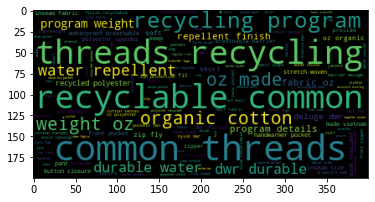

-----------
CLUSTER  0


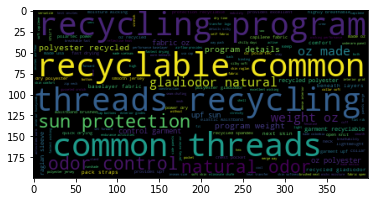

-----------
CLUSTER  4


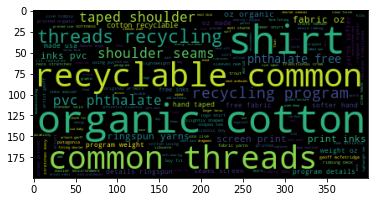

-----------
CLUSTER  -1


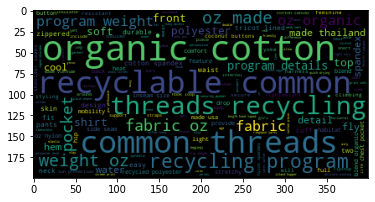

-----------
CLUSTER  2


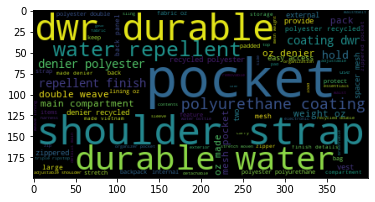

-----------


In [20]:
# Word cloud for the 5 first clusters
wd = wordcloud.WordCloud()
for c in corpus['cluster_id'].value_counts().index[:5] :
    print("CLUSTER ", c)
    texts = " ".join(corpus.loc[corpus['cluster_id']==c,'clean_description'])
    cloud = wd.generate(texts)
    plt.imshow(cloud)
    plt.show()
    print('-----------')

<hr style="border-width:2px;border-color:#75DFC1">
<center><h1>Systeme de recommandation</h1></center>
<hr style="border-width:2px;border-color:#75DFC1">

*Maintenant, nous utiliserons les clusters créés en partie 1 pour construire un système de recommandation. Le but est de pouvoir proposer à un utilisateur des produits similaires à ceux qui l'intéressent. Pour cela, on considère que les produits appartenant à un même cluster sont similaires.*

In [25]:
corpus.head()

,id,description,clean_description,clean_tokens,clean_document,cluster_id
0,1,Active classic boxers - There's a reason why o...,active classic boxers there s a reason why our...,"[active, classic, boxer, s, reason, boxer, cul...",active classic boxer s reason boxer cult favor...,0
1,2,Active sport boxer briefs - Skinning up Glory ...,active sport boxer briefs skinning up glory re...,"[active, sport, boxer, brief, skin, glory, req...",active sport boxer brief skin glory require mo...,0
2,3,Active sport briefs - These superbreathable no...,active sport briefs these superbreathable no f...,"[active, sport, brief, superbreathable, fly, b...",active sport brief superbreathable fly brief m...,0
3,4,"Alpine guide pants - Skin in, climb ice, switc...",alpine guide pants skin in climb ice switch to...,"[alpine, guide, pant, skin, climb, ice, switch...",alpine guide pant skin climb ice switch rock t...,1
4,5,"Alpine wind jkt - On high ridges, steep ice an...",alpine wind jkt on high ridges steep ice and a...,"[alpine, wind, jkt, high, ridges, steep, ice, ...",alpine wind jkt high ridges steep ice alpine j...,1


*Nous créons une fonction nommée find_similar_items qui renvoie les 5 identifiants d'articles appartenant au même cluster que le produit item_id qui est passé en arguments*

In [22]:
def find_similar_items(item_id):
    """
    Return 5 product ids belonging to the same cluster as item_id
    """
    cluster_id = corpus.loc[corpus['id']==item_id, 'cluster_id'].values[0]
    similar_items = corpus.loc[corpus['cluster_id']==cluster_id,:].sample(5)
    similar_item_ids = similar_items['id'].unique()
    return similar_item_ids

*Utilisation de la fonction input()  python pour permettre à l'utilisateur de choisir un produit et de soumettre des suggestions d'articles similaires*

In [23]:
# For printing in colors
class bcolors:
    OKBLUE = '\033[94m'
    OKGREEN = '\033[92m'

In [35]:
product_id = int(input("Quel produit souhaitez-vous acheter ? "))
print()
try:
    item_desc = corpus.loc[corpus['id']==product_id, 'clean_description'].values[0]
except:
    print('Produit introuvable dans la base de données. Veuillez entrer un identifiant de produit valide.')
else:
    print(f"{bcolors.OKBLUE}Produit trouvé dans la base de données, description ci-dessous:")
    print(item_desc)
    print()
    
    print("Vous pourriez également être intéressé par les produits suivants : ")
    print()

    for i in find_similar_items(product_id):
        print(f"{bcolors.OKGREEN}Item #", i)
        print(corpus.loc[corpus['id']==i, 'clean_description'].values[0])
        print('--------------------')

What product would you like to buy ? 1

Produit trouvé dans la base de données, description ci-dessous:
active classic boxers there s a reason why our boxers are a cult favorite they keep their cool especially in sticky situations the quick drying lightweight underwear takes up minimal space in a travel pack an exposed brushed waistband offers next to skin softness five panel construction with a traditional boxer back for a classic fit and a functional fly made of oz recycled polyester with moisture wicking performance inseam size m is recyclable through the common threads recycling program details silky capilene fabric is ultralight breathable and quick to dry exposed brushed elastic waistband for comfort panel construction with traditional boxer back inseam size m is fabric oz all recycled polyester with gladiodor natural odor control for the garment recyclable through the common threads recycling program weight g oz made in mexico 

Vous pourriez également être intéressé par les pro

<hr style="border-width:2px;border-color:#75DFC1">
<center><h1>LSA for topic extraction</h1></center>
<hr style="border-width:2px;border-color:#75DFC1">

* L'analyse sémantique latente, ou LSA, est l'une des techniques fondamentales de la modélisation thématique. L'idée centrale est de prendre une matrice de ce que nous avons - documents et termes - et de la décomposer en une matrice document-sujet et une matrice sujet-terme distinctes.

* L'objectif principal de cette partie est de trouver des sujets pertinents pour chaque document. Contrairement au clustering, un document unique peut avoir plusieurs sujets. Par exemple Sport et Politique.

*Utilisation de TruncatedSVD pour effectuer une extraction de sujet à partir de la matrice TF-IDF.*

In [28]:
# Train SVD model
svd_model = TruncatedSVD(n_components=12) # We test on 12 topics
lsa = svd_model.fit_transform(X)
topic_encoded_df = pd.DataFrame(lsa, columns = ["topic_" + str(i) for i in range(lsa.shape[1])])
topic_encoded_df["documents"] = corpus['clean_description']
topic_encoded_df.head() 

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,documents
0,0.275884,-0.041497,0.186293,0.097653,-0.122870,0.003141,-0.083772,-0.002649,-0.139815,-0.072116,-0.040569,-0.007077,active classic boxers there s a reason why our...
1,0.302458,-0.050474,0.103325,0.105894,-0.016129,0.146568,-0.022028,-0.006749,-0.083986,-0.106651,-0.060268,0.052258,active sport boxer briefs skinning up glory re...
2,0.296934,-0.077412,0.113182,0.028895,-0.029563,0.128836,0.078781,0.067171,-0.066026,-0.042338,-0.037443,0.105298,active sport briefs these superbreathable no f...
3,0.408583,-0.256600,-0.115917,-0.154086,0.042564,-0.023829,-0.045045,-0.117504,0.014674,-0.131436,-0.030311,-0.092714,alpine guide pants skin in climb ice switch to...
4,0.401699,-0.271033,-0.020146,-0.247766,-0.031972,-0.064545,0.039524,-0.000183,0.099931,-0.163773,-0.009054,-0.202125,alpine wind jkt on high ridges steep ice and a...


Contrairement au clustering, LSA permet de mapper chaque document sur un mélange de plusieurs sujets. Pour cette raison, il est un peu plus difficile d'interpréter les sujets comme des catégories : un document peut en fait être lié à plusieurs sujets à la fois. Pour faciliter les choses, nous pouvons extraire le sujet principal de chaque document.


* Création d'une nouvelle colonne nommée main_topic dans topic_encoded_df où nous stockons les principaux sujets liés à chaque document

In [29]:
def extract_main_topics(x):
    """
    Return the main topic for each document. The main topic is that have the maximum value for each line
    """
    topics = np.abs(x)
    main_topic = topics.sort_values(ascending=False).index[0]
    return main_topic

# Initialize column main_topics with 0
topic_encoded_df.loc[:, 'main_topic'] = 0

for i, row in topic_encoded_df.iloc[:,:-2].iterrows():
    topic_encoded_df.loc[i, 'main_topic'] = extract_main_topics(row)

topic_encoded_df.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,documents,main_topic
0,0.275884,-0.041497,0.186293,0.097653,-0.122870,0.003141,-0.083772,-0.002649,-0.139815,-0.072116,-0.040569,-0.007077,active classic boxers there s a reason why our...,topic_0
1,0.302458,-0.050474,0.103325,0.105894,-0.016129,0.146568,-0.022028,-0.006749,-0.083986,-0.106651,-0.060268,0.052258,active sport boxer briefs skinning up glory re...,topic_0
2,0.296934,-0.077412,0.113182,0.028895,-0.029563,0.128836,0.078781,0.067171,-0.066026,-0.042338,-0.037443,0.105298,active sport briefs these superbreathable no f...,topic_0
3,0.408583,-0.256600,-0.115917,-0.154086,0.042564,-0.023829,-0.045045,-0.117504,0.014674,-0.131436,-0.030311,-0.092714,alpine guide pants skin in climb ice switch to...,topic_0
4,0.401699,-0.271033,-0.020146,-0.247766,-0.031972,-0.064545,0.039524,-0.000183,0.099931,-0.163773,-0.009054,-0.202125,alpine wind jkt on high ridges steep ice and a...,topic_0


*Compter chaque sujet principal dans le corpus*

In [30]:
topic_encoded_df['main_topic'].value_counts()

# topic_0 is the most represented topic, as it's the main topic for more than 50% of the documents of the corpus.

topic_0     267
topic_1      61
topic_2      34
topic_6      32
topic_7      31
topic_3      19
topic_4      14
topic_5      13
topic_11     12
topic_10      8
topic_9       5
topic_8       4
Name: main_topic, dtype: int64

* Utilisation de l'attribut component_ du modèle SVD pour imprimer les 5 mots les plus importants dans chaque sujet

In [31]:
# Create DataFrame containing the description of each topic in terms of the words in the vocabulary
topics_description = pd.DataFrame(svd_model.components_, columns = vectorizer.get_feature_names(), 
                                  index = ['topic_' + str(i) for i in range(svd_model.components_.shape[0])])

# Compute absolute values of coefficients
topics_description = topics_description.apply(np.abs, axis = 1)

# Each word is map with a score of relevance for each topic
topics_description.head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,abandon,ability,able,abrasion,abrasive,abroad,absolute,absorb,absorption,abstract,...,yosemite,young,yvon,zest,zinger,zip,zipped,zipper,zippered,zone
topic_0,0.001126,0.002230,0.000388,0.019148,0.000777,0.000867,0.000931,0.001198,0.001322,0.001293,...,0.003082,0.000684,0.001502,0.001119,0.000628,0.089203,0.000877,0.103841,0.051830,0.007192
topic_1,0.000487,0.000752,0.000401,0.023043,0.000693,0.000896,0.000655,0.001718,0.001453,0.003813,...,0.006954,0.000476,0.004631,0.001480,0.000857,0.059049,0.000999,0.119862,0.059171,0.010470
topic_2,0.003466,0.005883,0.000056,0.018863,0.000156,0.000087,0.002262,0.001069,0.000608,0.000517,...,0.001370,0.000335,0.000612,0.000255,0.000798,0.071739,0.000372,0.064802,0.041845,0.000083
topic_3,0.000610,0.000236,0.000077,0.013599,0.000849,0.002053,0.000388,0.003246,0.000150,0.002214,...,0.005581,0.001122,0.003079,0.002827,0.000864,0.075636,0.001041,0.131394,0.052962,0.016727
topic_4,0.004414,0.009322,0.000737,0.017892,0.000882,0.000309,0.001952,0.000723,0.000405,0.000161,...,0.000452,0.000178,0.000640,0.000479,0.000411,0.015902,0.000091,0.004260,0.006161,0.020075


In [32]:
# Loop over each topic and print the 5 most important words
for i,row in topics_description.iterrows():
    print('TOPIC :', i)
    print(row.sort_values(ascending=False)[0:5].index.tolist())
    print()
    print('-------------------------')
    print()

TOPIC : topic_0
['recycle', 'pocket', 'oz', 'organic', 'cotton']

-------------------------

TOPIC : topic_1
['organic', 'cotton', 'shirt', 'print', 'ringspun']

-------------------------

TOPIC : topic_2
['merino', 'odor', 'pocket', 'wool', 'control']

-------------------------

TOPIC : topic_3
['inseam', 'organic', 'cotton', 'button', 'short']

-------------------------

TOPIC : topic_4
['merino', 'wool', 'sun', 'capilene', 'gladiodor']

-------------------------

TOPIC : topic_5
['nylon', 'spandex', 'sun', 'organic', 'cotton']

-------------------------

TOPIC : topic_6
['spandex', 'coverage', 'inseam', 'tencel', 'line']

-------------------------

TOPIC : topic_7
['strap', 'mesh', 'waterproof', 'barrier', 'polyurethane']

-------------------------

TOPIC : topic_8
['sun', 'upf', 'protection', 'fleece', 'collar']

-------------------------

TOPIC : topic_9
['sun', 'fleece', 'waterproof', 'protection', 'barrier']

-------------------------

TOPIC : topic_10
['photo', 'poster', 'outsi

* Créez un nuage de mots décrivant chaque sujet et comparez-le à ceux que nous obtenons avec le clustering

In [33]:
topic_encoded_df.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,documents,main_topic
0,0.275884,-0.041497,0.186293,0.097653,-0.122870,0.003141,-0.083772,-0.002649,-0.139815,-0.072116,-0.040569,-0.007077,active classic boxers there s a reason why our...,topic_0
1,0.302458,-0.050474,0.103325,0.105894,-0.016129,0.146568,-0.022028,-0.006749,-0.083986,-0.106651,-0.060268,0.052258,active sport boxer briefs skinning up glory re...,topic_0
2,0.296934,-0.077412,0.113182,0.028895,-0.029563,0.128836,0.078781,0.067171,-0.066026,-0.042338,-0.037443,0.105298,active sport briefs these superbreathable no f...,topic_0
3,0.408583,-0.256600,-0.115917,-0.154086,0.042564,-0.023829,-0.045045,-0.117504,0.014674,-0.131436,-0.030311,-0.092714,alpine guide pants skin in climb ice switch to...,topic_0
4,0.401699,-0.271033,-0.020146,-0.247766,-0.031972,-0.064545,0.039524,-0.000183,0.099931,-0.163773,-0.009054,-0.202125,alpine wind jkt on high ridges steep ice and a...,topic_0


-------------------------

TOPIC  topic_0


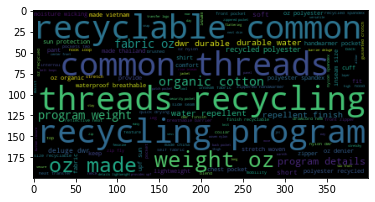


-------------------------

TOPIC  topic_1


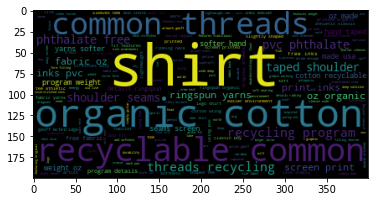


-------------------------

TOPIC  topic_2


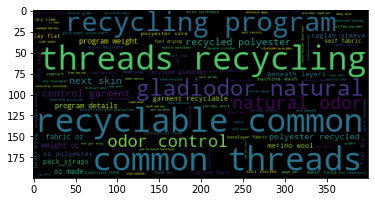


-------------------------

TOPIC  topic_3


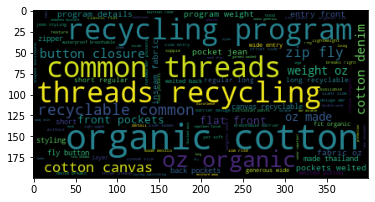


-------------------------

TOPIC  topic_4


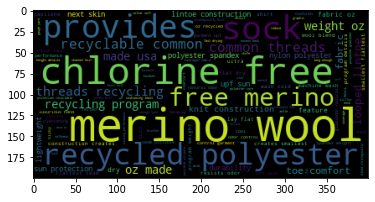


-------------------------

TOPIC  topic_5


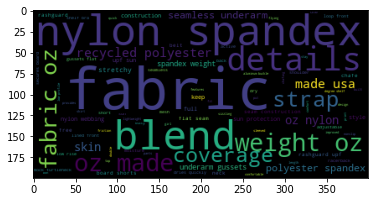


-------------------------

TOPIC  topic_6


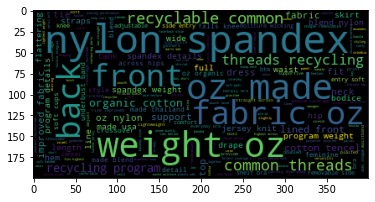


-------------------------

TOPIC  topic_7


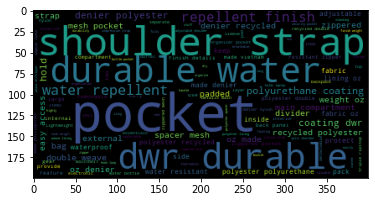


-------------------------

TOPIC  topic_8


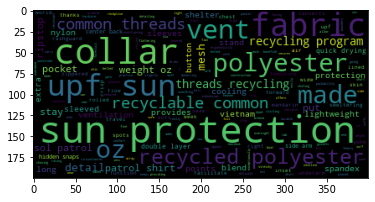


-------------------------

TOPIC  topic_9


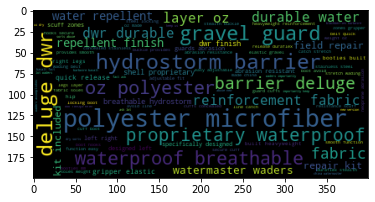


-------------------------

TOPIC  topic_10


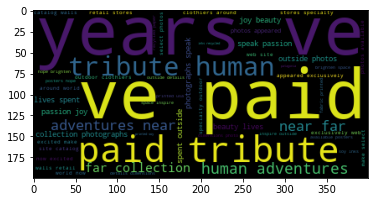


-------------------------

TOPIC  topic_11


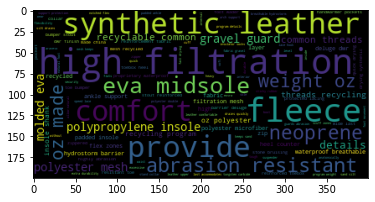

In [34]:
# Loop over each topic and create wordcloud from documents that are related to this main topic
wd = wordcloud.WordCloud()

cols = [c for c in topic_encoded_df.columns if 'topic_' in c]

for t in cols:
    print('-------------------------')
    print()
    print('TOPIC ', t)
    
    # Handle topics that are not main topics for any document in the corpus
    if (topic_encoded_df['main_topic']==t).any() == False :
        print('cannot create wordcloud for this topic')
        continue
    
    texts = " ".join(topic_encoded_df.loc[topic_encoded_df['main_topic']==t,'documents'])
    cloud = wd.generate(texts)
    plt.imshow(cloud)
    plt.show()
    
    print()

* Il est difficile de comparer les résultats du clustering et du LSA, notamment parce que nous n'avons pas obtenu exactement le même nombre de "topics" pour les deux algorithmes. Cependant, les nuages ​​de mots ne sont pas fondamentalement différents (par exemple, les deux algorithmes identifient un groupe de documents ou un sujet lié à la protection solaire, au coton biologique ou au bois mérinos).

* La principale différence entre ces deux approches est que le clustering mappe un document donné à un seul groupe, tandis que LSA relie un document à plusieurs sujets. Pour cette raison, le regroupement de texte est généralement plus adapté aux applications liées aux mesures de similarité (par exemple, la construction d'un système de recommandation), tandis que LSA est largement utilisé pour la modélisation de sujets.